In [1]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

Using TensorFlow backend.


Get MNIST

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]][0:1000]
x_test_38 = x_test[idx_test[3]+idx_test[8]][0:200]   

# y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
# print(np.count_nonzero(y_train_38[y_train_38==3]))

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
y_test_38 = y_test[idx_test[3]+idx_test[8]][0:200] 

In [3]:
# K-Means clustering to find centers
start = time.time()
kmeans_model = KMeans(2)
kmeans_model.fit(x_train[idx_train[8]+idx_train[3]])
_38=np.reshape(kmeans_model.cluster_centers_,(-1,784))
print("Cluster Production time(sec) :", time.time() - start)
# x_model = KMeans(100)
# x_model.fit(x_train)
# x = x_model.predict(x_model.cluster_centers_)
# x = keras.utils.to_categorical(x,100)

x = np.zeros((100,100))
for i in range(100):
    x[i][i] = 1

Cluster Production time(sec) : 5.33155632019043


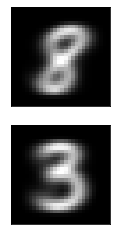

In [4]:
fig = plt.figure()

for i in range(2):
  subplot = fig.add_subplot(2,1, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(_38[i], (28, 28)), cmap='gray')

In [5]:
row = [random.randrange(0,22) for i in range(50)]
col = [random.randrange(0,22) for i in range(50)]
train_label=[]
train_image =[]
test_image=[]
test_label=[]

centers=[]

for cluster in _38:
    for i in range(50):
        centers.extend(cluster[r*28+col[i] : r*28+(col[i]+7) ] for r in range(row[i],row[i]+7))
centers = np.reshape(centers,(-1,49))


for i in range(1000):
    for j in range(50):
        train_image.extend(x_train_38[i][r*28+col[j] : r*28+(col[j]+7) ] for r in range(row[j],row[j]+7))
        train_label.extend(y_train_38[i])
train_image = np.reshape(train_image,(-1,49))
train_label = np.reshape(train_label,(-1,10))
            
for i in range(200):
    for j in range(50):
        test_image.extend(x_test_38[i][r*28+col[j] : r*28+(col[j]+7) ] for r in range(row[j],row[j]+7))
        test_label.extend(y_test_38[i])    
test_image = np.reshape(test_image,(-1,49))
test_label = np.reshape(test_label,(-1,10))
                                                                                                                                                                                                                                            
train_random = np.arange(train_image.shape[0])
np.random.shuffle(train_random)
test_random = np.arange(test_image.shape[0])
np.random.shuffle(test_random)

train_image = train_image[train_random]
train_label = train_label[train_random]
test_image = test_image[test_random]
test_label = test_label[test_random]


X_Train 이미지에서 10개의 Cluster 생성후 출력  

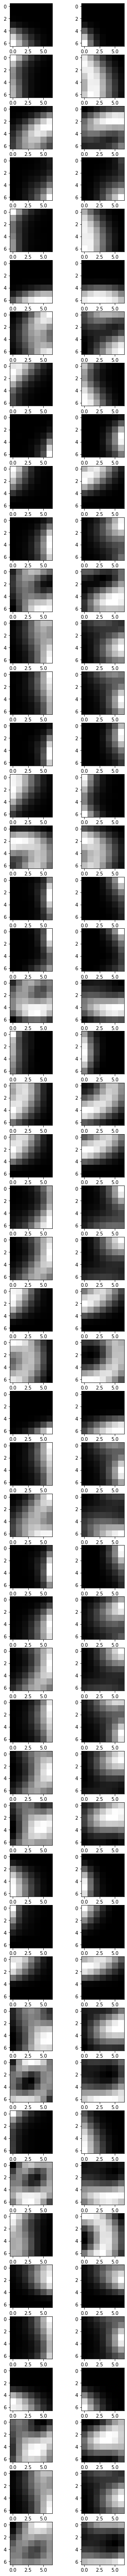

In [16]:
# plot cluster centers as images
imgs = centers * 255
fig = plt.figure(figsize =(5,100))
for i in range(50):
  subplot = fig.add_subplot(50,2, 2*i+1)
  subplot.imshow(np.reshape(centers[i], (7, 7)), cmap='gray')
  subplot = fig.add_subplot(50,2, 2*i+2)
  subplot.imshow(np.reshape(centers[i+50], (7, 7)), cmap='gray')
  
plt.savefig('rbf_centers.png')


# RBF Layer
kernel = PairwiseKernel(metric='polynomial') 
rbf_model = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(centers, x)
#
temp1 = rbf_model.predict(train_image)
temp2 = rbf_model.predict(test_image)

In [18]:
# Perceptron Layers
batch_size = 128
epochs = 100

model = Sequential()
model.add(Dense(10, activation='softmax', input_shape=(100,)))

model.summary()
nadam=keras.optimizers.Nadam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                1010      
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train model
history = model.fit(temp1, train_label,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(temp2, test_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 1s 23us/step - loss: 2.0311 - acc: 0.3902 - val_loss: 1.5411 - val_acc: 0.5232
Epoch 2/100
50000/50000 [==============================] - 1s 15us/step - loss: 1.3154 - acc: 0.5431 - val_loss: 1.1814 - val_acc: 0.5818
Epoch 3/100
50000/50000 [==============================] - 1s 15us/step - loss: 1.0705 - acc: 0.5905 - val_loss: 1.0145 - val_acc: 0.6145
Epoch 4/100
50000/50000 [==============================] - 1s 15us/step - loss: 0.9411 - acc: 0.6153 - val_loss: 0.9100 - val_acc: 0.6305
Epoch 5/100
50000/50000 [==============================] - 1s 16us/step - loss: 0.8573 - acc: 0.6261 - val_loss: 0.8404 - val_acc: 0.6376
Epoch 6/100
50000/50000 [==============================] - 1s 15us/step - loss: 0.7988 - acc: 0.6339 - val_loss: 0.7906 - val_acc: 0.6428
Epoch 7/100
50000/50000 [==============================] - 1s 18us/step - loss: 0.7564 - acc: 0.6362 - val_loss: 0.7544 - 

In [22]:
predictions = model.predict(temp1)
print(predictions[3])

[0.    0.    0.    0.297 0.    0.    0.    0.    0.703 0.   ]


In [13]:
# Evaluate model
score = model.evaluate(temp2, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6408358578681945
Test accuracy: 0.6073
